## 영화 리뷰 감성분석을 해보자

In [1]:
import numpy as np
import tensorflow as tf
import os
from konlpy.tag import Mecab
from collections import Counter

In [2]:
def get_decoded_sentence(raw_sentence,index_to_word):
    return ' '.join(index_to_word[idx] if idx in index_to_word else "<UNK>" for idx in raw_sentence[1:])

def get_decoded_sentences(raw_sens,index_to_word):
    return [get_decoded_sentence(sentence,index_to_word) for sentence in raw_sens]

### 기본적인 함수 준비
* get_decoded_sentence : 인덱스로 구성된 문장을 원본 문장으로 매핑하는 함수.
* get_decoded_sentences : 리스트로 받은 문장들을 원본 문장으로 각각 매핑해 리스트로 반환하는 함수.

In [3]:
#훈련을 위한 영화 리뷰 데이터를 다운받습니다.
imdb = tf.keras.datasets.imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

* load_data() 호출 시 인자로 전달된 num_words는 단어사전에 등재할 단어의 개수로 이 개수만큼 딕셔너리까지 생성된 형태로 데이터셋이 생성됩니다.

In [4]:
#다운받은 데이터를 확인해봅시다.
print(x_train[0])
print("라벨 : ",y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨 :  1


In [5]:
#제공되는 딕셔너리를 저장합니다.
word_to_index = imdb.get_word_index()
#제공된 딕셔너리를 이용해 idx에서 word로 변환하는 딕셔너리를 정의합니다.
index_to_word = {index:word for word,index in word_to_index.items()}
print("1번 인덱스가 뭔가요 : ",index_to_word[1])
print("the는 몇번 인덱스인가요 : ",word_to_index['the'])

1번 인덱스가 뭔가요 :  the
the는 몇번 인덱스인가요 :  1


In [6]:
#train set의 0번에는 어떤 문장이 있을지 출력해봅시다.
print(get_decoded_sentence(x_train[0],index_to_word))

as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have two of

### 그래서 이게 대체 무슨말인데?
* 출력된 문장을 보면 의미모를 문장이 출력이 되는데 왜그럴까요?
* 실제로 인코딩된 인덱스는 word_to_index에서 index를 기준으로 3씩 뒤로 밀려있습니다. 0~3번까지의 인덱스는 사전에 정의되어 있기 때문입니다.
* 따라서 word_to_index는 아래처럼 보정되어야합니다.

In [7]:
#매핑된 인덱스를 3씩 올려줍니다.
word_to_index = {k:(v+3) for k,v in word_to_index.items()}
#사전에 정의된 인덱스는 따로 처리!
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3
#재정의된 word_to_index에 맞게 재정의해줍니다.
index_to_word = {index:word for word,index in word_to_index.items()}

In [8]:
#보정된 딕셔너리로 번역된 문장입니다.
print(get_decoded_sentence(x_train[0],index_to_word))

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

* 딕셔너리를 보정하니 올바른 문장이 출력됩니다.

### 잊지맙시다.
* 모델에 문장을 학습시켜주기 위해 keras의 pad_sequences 함수로 모든 문장의 길이를 통일시켜주어야 합니다.
* 또, 문장의 최대길이 설정도 전체 모델 성능에 영향을 미치기에 적절한 값을 찾기위해 전체 데이터셋의 분포를 확인해 보도록 합시다.

In [9]:
#전체 데이터에 적용시킬 수 있을만한 maxlen값을 찾도록 하겠습니다.
total_data_text = list(x_train)+list(x_test)
#문장의 길이를 리스트로 저장한뒤 numpy함수를 사용하기 위해 numpy 리스트로 변환합니다.
num_tokens = [len(token) for token in total_data_text]
num_tokens = np.array(num_tokens)

print("문장 길이의 평균 :", np.mean(num_tokens))
print("문장 길이의 최대 :", np.max(num_tokens))
print("문장 길이의 표준편차 :", np.std(num_tokens))
#임시로 maxlen을 평균 + 2 * 표준편차라고 한다면,
max_tokens = np.mean(num_tokens)+2*np.std(num_tokens)
#실수형 데이터를 정수로 바꿔줍니다.
maxlen = int(max_tokens)
print("전체 문장의 {}%가 maxlen값 이내에 포함됩니다.".format(np.sum(num_tokens<max_tokens)/len(num_tokens)))

문장 길이의 평균 : 234.75892
문장 길이의 최대 : 2494
문장 길이의 표준편차 : 172.91149458735703
전체 문장의 0.94536%가 maxlen값 이내에 포함됩니다.


In [10]:
#얻은 maxlen을 이용해 문장의 길이를 통일시킵니다.
print(x_train.shape)
#padding을 추가하는 위치는 post와 pre가 있습니다.
pre_x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value = word_to_index["<PAD>"],
                                                        padding='pre',
                                                       maxlen=maxlen)
pre_x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                        value = word_to_index["<PAD>"],
                                                        padding='pre',
                                                       maxlen=maxlen)
post_x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value = word_to_index["<PAD>"],
                                                        padding='post',
                                                       maxlen=maxlen)
post_x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                        value = word_to_index["<PAD>"],
                                                        padding='post',
                                                       maxlen=maxlen)
print(pre_x_train.shape)
print(pre_x_train[0])

(25000,)
(25000, 580)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0

### 문장 길이가 통일되었습니다.
* 길이를 늘여 빈공간에 pad문자를 넣게되는데 padding 인자를 통해 pre또는 post에 pad문자를 삽입할 수 있습니다.
#### padding방식은 pre와 post 무엇이 더 유리할까요?
* RNN은 입력데이터를 순차적으로 처리하며, 마지막 입력이 state에 가장 큰 영향을 미치게 됩니다. 따라서 마지막 데이터가 의미가없는 pad 문자인 것은 비효율적이며 pre가 더 유리하다고 볼 수 있습니다.

### 성능을 확인해 봅시다.
* RNN모델을 학습하여 성능을 평가해봅시다.
* 그리고 과연 padding pre,post가 성능차이가 얼마나 나는지 확인해봅시다.

In [11]:
#모델 훈련을 위해 데이터를 나눠줍니다.
#검증데이터
pre_x_val = pre_x_train[:10000]
post_x_val = post_x_train[:10000]
y_val = y_train[:10000]
#학습데이터
pre_partial_x_train = pre_x_train[10000:]
post_partial_x_train = post_x_train[10000:]
y_train = y_train[10000:]

In [12]:
vocab_size = 10000
word_vector_dim = 16
#데이터에 따라 모델을 각각 준비합니다.
pre_model = tf.keras.Sequential()
pre_model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim,input_shape=(None,)))
pre_model.add(tf.keras.layers.LSTM(8))
pre_model.add(tf.keras.layers.Dense(8,activation='relu'))
pre_model.add(tf.keras.layers.Dense(1,activation='sigmoid'))#출력값은 0,1 둘 중 하나면 됩니다

post_model = tf.keras.Sequential()
post_model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim,input_shape=(None,)))
post_model.add(tf.keras.layers.LSTM(8))
post_model.add(tf.keras.layers.Dense(8,activation='relu'))
post_model.add(tf.keras.layers.Dense(1,activation='sigmoid'))


In [13]:
epochs = 10

In [14]:
pre_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

pre_history = pre_model.fit(pre_partial_x_train,
                           y_train,
                           epochs=epochs,
                           batch_size = 512,
                           validation_data=(pre_x_val,y_val),
                           verbose = 1)

Epoch 1/10
30/30 [==============================] - 5s 45ms/step - loss: 0.6904 - accuracy: 0.5657 - val_loss: 0.6844 - val_accuracy: 0.6236
Epoch 2/10
30/30 [==============================] - 1s 28ms/step - loss: 0.6640 - accuracy: 0.7163 - val_loss: 0.6348 - val_accuracy: 0.6925
Epoch 3/10
30/30 [==============================] - 1s 28ms/step - loss: 0.5284 - accuracy: 0.7866 - val_loss: 0.4568 - val_accuracy: 0.8221
Epoch 4/10
30/30 [==============================] - 1s 28ms/step - loss: 0.3954 - accuracy: 0.8648 - val_loss: 0.4003 - val_accuracy: 0.8497
Epoch 5/10
30/30 [==============================] - 1s 28ms/step - loss: 0.3149 - accuracy: 0.8990 - val_loss: 0.3715 - val_accuracy: 0.8467
Epoch 6/10
30/30 [==============================] - 1s 28ms/step - loss: 0.2509 - accuracy: 0.9241 - val_loss: 0.3457 - val_accuracy: 0.8632
Epoch 7/10
30/30 [==============================] - 1s 27ms/step - loss: 0.2026 - accuracy: 0.9419 - val_loss: 0.3448 - val_accuracy: 0.8612
Epoch 8/10
30

In [15]:
post_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

post_history = post_model.fit(post_partial_x_train,
                           y_train,
                           epochs=epochs,
                           batch_size = 512,
                           validation_data=(post_x_val,y_val),
                           verbose = 1)

Epoch 1/10
30/30 [==============================] - 2s 40ms/step - loss: 0.6931 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4949
Epoch 2/10
30/30 [==============================] - 1s 28ms/step - loss: 0.6930 - accuracy: 0.5093 - val_loss: 0.6932 - val_accuracy: 0.4968
Epoch 3/10
30/30 [==============================] - 1s 28ms/step - loss: 0.6927 - accuracy: 0.5088 - val_loss: 0.6933 - val_accuracy: 0.4976
Epoch 4/10
30/30 [==============================] - 1s 28ms/step - loss: 0.6921 - accuracy: 0.5139 - val_loss: 0.6927 - val_accuracy: 0.5079
Epoch 5/10
30/30 [==============================] - 1s 27ms/step - loss: 0.6895 - accuracy: 0.5065 - val_loss: 0.6924 - val_accuracy: 0.5021
Epoch 6/10
30/30 [==============================] - 1s 28ms/step - loss: 0.6838 - accuracy: 0.5301 - val_loss: 0.6924 - val_accuracy: 0.5043
Epoch 7/10
30/30 [==============================] - 1s 27ms/step - loss: 0.6781 - accuracy: 0.5233 - val_loss: 0.6959 - val_accuracy: 0.5060
Epoch 8/10
30

#### 성능 평가 비교

In [16]:
pre_loss,pre_acc = pre_model.evaluate(pre_x_test,  y_test, verbose=2)
post_loss,post_acc = post_model.evaluate(post_x_test,  y_test, verbose=2)
print("padding의 위치에 따른 정확도 비교 -> pre : {}% post : {}%".format(int(pre_acc*100),
                                                            int(post_acc*100)))

782/782 - 5s - loss: 0.3933 - accuracy: 0.8510
782/782 - 5s - loss: 0.6898 - accuracy: 0.5130
padding의 위치에 따른 정확도 비교 -> pre : 85% post : 51%


### padding 위치에 따른 성능 차이가..
* 학습 과정을 보더라도 pre padding은 학습이 잘 되는 것을 볼 수 있지만,<br> post padding의 경우 학습이 거의 진행되지 않는것을 볼 수 있습니다.
* post 모델도 pre_x_test로 평가하니 정확도가 70퍼센트 정도 나오긴 합니다만 여전히 pre 모델의 정확도가 우세합니다.
* post_x_test로 평가했을땐 그저 무의미하게 선택하여 정확도가 50퍼센트가량 나오는 것을 볼 수 있습니다.
* post의 경우 무의미한 값을 연속으로 계속 받게되어 학습이 잘 되지 않다고 생각해 볼 수 있겠습니다.

### 학습한 모델의 임베딩을 확인해봅시다.
* 임베딩 레이어는 사전의 단어 개수 X 워드 벡터 사이즈만큼의 크기를 가집니다.
* 의미가 유사한 단어일수록 워드 벡터가 유사하겠죠?
* 정말 그렇게 학습되었는지 확인해봅시다.

In [17]:
#학습한 임베딩 파라미터를 파일에 저장합니다.
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path,'w')
#몇개의 벡터를 얼마 사이즈로 쓸 것인지 타이틀로 기록합니다.
f.write('{} {}\n'.format(vocab_size-4,word_vector_dim))

vectors = pre_model.get_weights()[0]
# 첫 특수문자 4개를 제외하고 모두 파일에 기록합니다.
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i],' '.join(map(str,list(vectors[i,:])))))


f.close()

* gensim에서 제공하는 패키지를 이용해 파일로 된 워드 임베딩 파라미터를 읽어 word vector로 활용할 수 있습니다.

In [18]:
from gensim.models.keyedvectors import Word2VecKeyedVectors as w2v
#파일로 된 워드 임베딩을 불러옵니다.
word_vectors = w2v.load_word2vec_format(word2vec_file_path,binary = False)
#computer의 워드 벡터를 확인합시다.
vector = word_vectors['computer']
vector

array([-0.00334141,  0.02113689,  0.0290336 ,  0.01175037, -0.03285229,
       -0.02958348, -0.03962233,  0.03338094, -0.00960125, -0.02839767,
       -0.03380265, -0.01193141,  0.03088752,  0.01006512,  0.03128016,
       -0.02682097], dtype=float32)

### 유사한 단어를 찾아봅시다.
* 유사한 단어라면 워드 벡터도 비슷할텐데요, 정말로 워드 벡터가 비슷한지 확인해보도록 하겠습니다.

In [19]:
word_vectors.similar_by_word("love")

[('lang', 0.9486479759216309),
 ('mesmerizing', 0.9338877201080322),
 ('realizing', 0.9315872192382812),
 ('din', 0.9301005601882935),
 ('today', 0.9267585277557373),
 ('perfect', 0.9175127148628235),
 ('soylent', 0.9168857932090759),
 ('hooked', 0.9118993282318115),
 ('2002', 0.9108335375785828),
 ('2009', 0.90580815076828)]

#### 이게 love와 비슷한 단어라고?
* 그렇게 유사하지는 않은 것 같은데 아무래도 워드 벡터의 차원도 16개밖에 안되고 훈련 데이터도 많지않아 워드 벡터가 정교하게 학습시키기 힘들었던것 같습니다.

### 그렇다면 사전에 잘 학습된 워드 임베딩 모델은 어떨까요?
* Google News dataset으로 학습된 Word2Vec이라는 워드 임베딩 모델을 활용해 보도록 하겠습니다.

In [20]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = w2v.load_word2vec_format(word2vec_path,binary = True,limit = 1000000)
vector = word2vec['computer']
#300차원의 워드 벡터입니다.
print(vector.shape)

(300,)


In [21]:
word2vec.similar_by_word("love")

[('loved', 0.6907792091369629),
 ('adore', 0.6816873550415039),
 ('loves', 0.6618633270263672),
 ('passion', 0.6100709438323975),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547305345535278),
 ('absolutely_adore', 0.5536839962005615),
 ('adores', 0.5440906882286072)]

* 이번엔 유사한 단어를 잘 찾은것 같습니다.

In [22]:
vocab_size = 10000
word_vector_dim = 300
embedding_matrix = np.random.rand(vocab_size,word_vector_dim)
#단어사전에 존재하는 단어별 워드 벡터를 복사합니다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [23]:
from tensorflow.keras.initializers import Constant

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(pre_partial_x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(pre_x_val, y_val),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 3s 69ms/step - loss: 0.6814 - accuracy: 0.5699 - val_loss: 0.6538 - val_accuracy: 0.6558
Epoch 2/10
30/30 [==============================] - 2s 56ms/step - loss: 0.5949 - accuracy: 0.7241 - val_loss: 0.5346 - val_accuracy: 0.7526
Epoch 3/10
30/30 [==============================] - 2s 55ms/step - loss: 0.4291 - accuracy: 0.8226 - val_loss: 0.4222 - val_accuracy: 0.8179
Epoch 4/10
30/30 [==============================] - 2s 56ms/step - loss: 0.3224 - accuracy: 0.8771 - val_loss: 0.4104 - val_accuracy: 0.8187
Epoch 5/10
30/30 [==============================] - 2s 56ms/step - loss: 0.2598 - accuracy: 0.9065 - val_loss: 0.3843 - val_accuracy: 0.8387
Epoch 6/10
30/30 [==============================] - 2s 56ms/step - loss: 0.2160 - accuracy: 0.9270 - val_loss: 0.3934 - val_accuracy: 0.8396
Epoch 7/10
30/30 [==============================] - 2s 56ms/step - loss: 0.1819 - accuracy: 0.9427 - val_loss: 0.4003 - val_accuracy: 0.8388
Epoch 8/10
30

In [26]:
model_loss,model_acc = model.evaluate(pre_x_test,y_test,verbose=2)
print("모델의 정확도는 {}% 입니다.".format(int(model_acc*100)))

782/782 - 5s - loss: 0.4653 - accuracy: 0.8335
모델의 정확도는 83% 입니다.


#  프로젝트 : 네이버 영화리뷰 감정분석하기

### 데이터를 가져옵니다.
* 데이터 다운로드 링크 https://github.com/e9t/nsmc/

In [27]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 데이터를 정제할 함수

In [28]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=19000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

### 데이터의 정제 과정입니다.
1. 원본 데이터에서 feature와 label을 분리합니다.
2. 인덱스와 단어를 매핑할 딕셔너리를 작성합니다.
3. 데이터에 pad문자를 넣어 길이를 맞추어 줍니다.

In [29]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

/tmp/ipykernel_1728/325033547.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_1728/325033547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_1728/325033547.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_1728/325033547.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [30]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(X_train[:3])
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

[[27, 67, 895, 33, 214, 15, 28, 699], [977, 481, 491, 636, 4, 110, 1554, 48, 866, 949, 11, 38, 364], [19, 192, 3]]


In [31]:
#전체 데이터에 적용시킬 수 있을만한 maxlen값을 찾도록 하겠습니다.
total_data_text = list(X_train)+list(X_test)
#문장의 길이를 리스트로 저장한뒤 numpy함수를 사용하기 위해 numpy 리스트로 변환합니다.
num_tokens = [len(token) for token in total_data_text]
num_tokens = np.array(num_tokens)

print("문장 길이의 평균 :", np.mean(num_tokens))
print("문장 길이의 최대 :", np.max(num_tokens))
print("문장 길이의 표준편차 :", np.std(num_tokens))
#임시로 maxlen을 평균 + 2 * 표준편차라고 한다면,
max_tokens = np.mean(num_tokens)+2*np.std(num_tokens)
#실수형 데이터를 정수로 바꿔줍니다.
maxlen = int(max_tokens)
print("전체 문장의 {}%가 maxlen값 이내에 포함됩니다.".format(np.sum(num_tokens<max_tokens)/len(num_tokens)))

문장 길이의 평균 : 13.718233430088207
문장 길이의 최대 : 83
문장 길이의 표준편차 : 11.469848902034261
전체 문장의 0.9340019146202243%가 maxlen값 이내에 포함됩니다.


In [32]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value = word_to_index["<PAD>"],
                                                        padding='pre',
                                                       maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value = word_to_index["<PAD>"],
                                                        padding='pre',
                                                       maxlen=maxlen)
print(X_train[0])
print(X_test[0])
print(X_train.shape)
print(X_test.shape)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  27  67 895  33 214  15  28 699]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 788 128]
(146182, 36)
(49157, 36)


In [33]:
X_val = X_train[:40000]
y_val = y_train[:40000]
X_train = X_train[40000:]
y_train = y_train[40000:]

In [34]:
vocab_size = 19000
word_vector_dim = 32
epochs = 6

In [35]:
first_model = tf.keras.Sequential()
first_model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim,input_shape=(None,)))
first_model.add(tf.keras.layers.LSTM(128))
first_model.add(tf.keras.layers.Dense(8,activation='relu'))
first_model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

second_model = tf.keras.Sequential()
second_model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim,input_shape=(None,)))
second_model.add(tf.keras.layers.LSTM(128))
second_model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

third_model = tf.keras.Sequential()
third_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
third_model.add(tf.keras.layers.MaxPooling1D(5))
third_model.add(tf.keras.layers.GlobalMaxPooling1D())
third_model.add(tf.keras.layers.Dense(8, activation='relu'))
third_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [36]:
first_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

first_history = first_model.fit(X_train,
                           y_train,
                           epochs=epochs,
                           batch_size = 512,
                           validation_data=(X_val,y_val),
                           verbose = 1)
second_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

second_history = second_model.fit(X_train,
                           y_train,
                           epochs=epochs,
                           batch_size = 512,
                           validation_data=(X_val,y_val),
                           verbose = 1)

third_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

third_history = third_model.fit(X_train,
                           y_train,
                           epochs=epochs,
                           batch_size = 512,
                           validation_data=(X_val,y_val),
                           verbose = 1)

Epoch 1/6
208/208 [==============================] - 4s 11ms/step - loss: 0.4643 - accuracy: 0.7691 - val_loss: 0.3670 - val_accuracy: 0.8390
Epoch 2/6
208/208 [==============================] - 2s 9ms/step - loss: 0.3352 - accuracy: 0.8553 - val_loss: 0.3571 - val_accuracy: 0.8426
Epoch 3/6
208/208 [==============================] - 2s 9ms/step - loss: 0.3083 - accuracy: 0.8702 - val_loss: 0.3585 - val_accuracy: 0.8419
Epoch 4/6
208/208 [==============================] - 2s 9ms/step - loss: 0.2861 - accuracy: 0.8820 - val_loss: 0.3619 - val_accuracy: 0.8415
Epoch 5/6
208/208 [==============================] - 2s 9ms/step - loss: 0.2650 - accuracy: 0.8915 - val_loss: 0.3843 - val_accuracy: 0.8385
Epoch 6/6
208/208 [==============================] - 2s 9ms/step - loss: 0.2444 - accuracy: 0.9015 - val_loss: 0.3879 - val_accuracy: 0.8378
Epoch 1/6
208/208 [==============================] - 3s 10ms/step - loss: 0.4613 - accuracy: 0.7805 - val_loss: 0.3643 - val_accuracy: 0.8404
Epoch 2/6
2

In [37]:
model_loss,model_acc = first_model.evaluate(X_test,y_test,verbose=2)
print("모델의 정확도는 {}% 입니다.".format(int(model_acc*100)))
model_loss,model_acc = second_model.evaluate(X_test,y_test,verbose=2)
print("모델의 정확도는 {}% 입니다.".format(int(model_acc*100)))
model_loss,model_acc = third_model.evaluate(X_test,y_test,verbose=2)
print("모델의 정확도는 {}% 입니다.".format(int(model_acc*100)))

1537/1537 - 3s - loss: 0.3958 - accuracy: 0.8329
모델의 정확도는 83% 입니다.
1537/1537 - 3s - loss: 0.3934 - accuracy: 0.8387
모델의 정확도는 83% 입니다.
1537/1537 - 2s - loss: 0.4142 - accuracy: 0.8235
모델의 정확도는 82% 입니다.


### 그래프 시각화

In [38]:
history_dict = second_history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


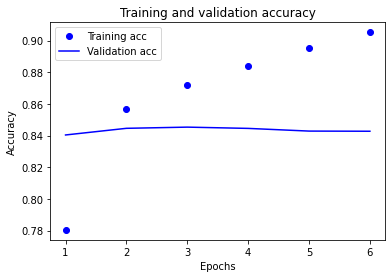

In [39]:
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [40]:
import gensim

### 한국어 임베딩 파일을 가져옵니다.

In [41]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)


In [84]:
print(word2vec)
word2vec.wv.most_similar("정열")

Word2Vec(vocab=30185, size=200, alpha=0.025)


[('열정', 0.7087529897689819),
 ('욕망', 0.670029878616333),
 ('감성', 0.6616932153701782),
 ('애정', 0.654250979423523),
 ('아름다움', 0.6380821466445923),
 ('상상력', 0.6374208331108093),
 ('슬픔', 0.6216992139816284),
 ('애국심', 0.6152282953262329),
 ('독창성', 0.610627293586731),
 ('기쁨', 0.6095349788665771)]

* 유사한 단어끼리 아주 잘묶여있는 것을 볼 수 있습니다.

### 이하 과정은 동일합니다.

In [64]:
X_train,y_train,X_test,y_test,word_to_index = load_data(train_data,test_data,25000)

/tmp/ipykernel_1728/325033547.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_1728/325033547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_1728/325033547.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_1728/325033547.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [65]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

In [66]:
index_to_word = {index:word for word,index in word_to_index.items()}

In [67]:
#전체 데이터에 적용시킬 수 있을만한 maxlen값을 찾도록 하겠습니다.
total_data_text = list(X_train)+list(X_test)
#문장의 길이를 리스트로 저장한뒤 numpy함수를 사용하기 위해 numpy 리스트로 변환합니다.
num_tokens = [len(token) for token in total_data_text]
num_tokens = np.array(num_tokens)

print("문장 길이의 평균 :", np.mean(num_tokens))
print("문장 길이의 최대 :", np.max(num_tokens))
print("문장 길이의 표준편차 :", np.std(num_tokens))
#임시로 maxlen을 평균 + 2 * 표준편차라고 한다면,
max_tokens = np.mean(num_tokens)+2*np.std(num_tokens)
#실수형 데이터를 정수로 바꿔줍니다.
maxlen = int(max_tokens)
print("전체 문장의 {}%가 maxlen값 이내에 포함됩니다.".format(np.sum(num_tokens<max_tokens)/len(num_tokens)))

문장 길이의 평균 : 13.718233430088207
문장 길이의 최대 : 83
문장 길이의 표준편차 : 11.469848902034261
전체 문장의 0.9340019146202243%가 maxlen값 이내에 포함됩니다.


In [68]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value = word_to_index["<PAD>"],
                                                        padding='pre',
                                                       maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value = word_to_index["<PAD>"],
                                                        padding='pre',
                                                       maxlen=maxlen)

In [69]:
X_val = X_train[:30000]
y_val = y_train[:30000]
X_train = X_train[30000:]
y_train = y_train[30000:]

In [70]:
vocab_size = 25000
word_vector_dim = 200
epochs = 4
embedding_matrix = np.random.rand(vocab_size,word_vector_dim)
#단어사전에 존재하는 단어별 워드 벡터를 복사합니다.
for i in range(vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
print(index_to_word[4])        
print(embedding_matrix[4])
print(word2vec[index_to_word[4]])

영화
[-1.75778365 -1.08742785  1.53008664 -0.1115231  -0.37980682  1.48285174
  1.31804192  0.11094163  0.7430535  -0.45461136  0.58841336  0.57639128
  1.21070695  1.31327951 -0.86962503 -0.18507595 -0.47440064  1.51007247
  1.09657943  1.06008232 -0.27457932 -0.70003706  2.31175113  1.49448836
  0.25560892 -2.86665893 -0.28312334  0.34263936 -0.67723423  0.71714777
  0.25549442  0.71732044 -0.13262457  0.01792452 -0.31847739  0.5271619
  0.7561084  -2.12470651  1.06142902 -0.21065854  0.68773431 -1.49563825
  0.60346967 -2.6955893   0.37694618 -1.01641846  0.54306632  0.1200121
 -2.63157177  0.62167418  1.15839756 -2.53859615  1.32631195 -0.10284371
 -0.0286147  -0.91329467  0.76475638  0.79202783 -1.86259568 -0.74183953
  0.58842772 -0.99179918 -0.62114453  1.53678155 -0.66289389  0.67121029
  0.12914915  0.21228492  0.90176553 -0.25083402  0.71500814  0.08644514
  0.59993285  0.57661372  0.64095974  0.47888306 -2.84262133 -2.85026813
 -0.140544   -1.59173644  0.26691505  0.59476066  

/tmp/ipykernel_1728/2772009982.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_1728/2772009982.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]
/tmp/ipykernel_1728/2772009982.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(word2vec[index_to_word[4]])


In [81]:
final_model = tf.keras.Sequential()
final_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
final_model.add(tf.keras.layers.LSTM(256))
final_model.add(tf.keras.layers.Dense(16,activation='relu'))
final_model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [82]:
final_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

final_history = final_model.fit(X_train,
                           y_train,
                           epochs=epochs,
                           batch_size = 512,
                           validation_data=(X_val,y_val),
                           verbose = 1)

Epoch 1/4
227/227 [==============================] - 8s 29ms/step - loss: 0.4555 - accuracy: 0.7787 - val_loss: 0.3699 - val_accuracy: 0.8332
Epoch 2/4
227/227 [==============================] - 6s 28ms/step - loss: 0.3265 - accuracy: 0.8572 - val_loss: 0.3330 - val_accuracy: 0.8544
Epoch 3/4
227/227 [==============================] - 6s 28ms/step - loss: 0.2700 - accuracy: 0.8881 - val_loss: 0.3291 - val_accuracy: 0.8576
Epoch 4/4
227/227 [==============================] - 6s 28ms/step - loss: 0.2290 - accuracy: 0.9067 - val_loss: 0.3525 - val_accuracy: 0.8561


In [83]:
model_loss,model_acc = final_model.evaluate(X_test,y_test,verbose=2)
print("모델의 정확도는 {}% 입니다.".format(int(model_acc*100)))

1537/1537 - 3s - loss: 0.3558 - accuracy: 0.8544
모델의 정확도는 85% 입니다.


## 회고합시다.
#### 이번 프로젝트를 진행하며 예상치 못한 오류들을 매우 많이 만났습니다.
* load_word2vec_format의 encoding 오류는 Word2Vec.load 함수로 교체하여 해결했습니다.
* vocab이라는 속성이 gensim에서 사라졌기 때문에 다운그레이드 하지 않으면 오류가 발생합니다.(pip install --upgrade gensim==3.8.3)

#### 성능 향상
* train set의 비율을 기존보다 조금 올려보니 약간의 성능 향상을 볼 수 있었습니다.
* 반복 학습의 효과가 미미했기 때문에 epoch는 4회가 가장 높은 성능을 보였습니다.
* 또, pre trained model을 사용하면 그렇지 않은 model보다 기본적으로 높은 정확도를 노릴 수 있었습니다.